In [ ]:
#!pip3 install --upgrade pip
#!pip3 install tensorflow
#!pip3 install pandas
#!pip3 install numpy
#!pip3 install gc
#!pip3 install matplotlib
#!pip3 install random
#!pip install scikit-learn
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping
import gc
from sklearn.metrics import accuracy_score, f1_score as f1, classification_report
from tensorflow.keras.utils import to_categorical
import random

# Load Data

In [ ]:
X_train = pd.read_csv('X_train.csv')
X_val = pd.read_csv('X_val.csv')
X_test = pd.read_csv('X_test.csv')
y_train = pd.read_csv('y_train.csv')
y_val = pd.read_csv('y_val.csv')
y_test = pd.read_csv('y_test.csv')


# Binary Models: Mental Health related vs. Normal

Baseline Model: majority class predictor

In [ ]:
#Convert labels to either 0 (normal) or 1 (abnormal) for binary model
# Map the labels into two categories: 'normal' and 'abnormal'
y_train_binary = np.where(y_train == 3, 0, 1)  # 0 for 'Normal', 1 for 'Abnormal'
y_val_binary = np.where(y_val == 3, 0, 1)
y_test_binary = np.where(y_test == 3, 0, 1)

# Verify the transformation
print("Binary labels distribution:")
print(f"Training set - Normal: {np.sum(y_train_binary == 0)}, Abnormal: {np.sum(y_train_binary == 1)}")
print(f"Validation set - Normal: {np.sum(y_val_binary == 0)}, Abnormal: {np.sum(y_val_binary == 1)}")
print(f"Test set - Normal: {np.sum(y_test_binary == 0)}, Abnormal: {np.sum(y_test_binary == 1)}")

Binary labels distribution:
Training set - Normal: 9616, Abnormal: 21908
Validation set - Normal: 3308, Abnormal: 7200
Test set - Normal: 3281, Abnormal: 7228


In [ ]:
#predicting majority class, abnormal
y_pred_majority = np.ones_like(y_test_binary)
majority_accuracy = accuracy_score(y_test_binary, y_pred_majority)
print(f"Majority Class Accuracy: {majority_accuracy}")

Majority Class Accuracy: 0.6877914168807688


The Majority Class Classifier has an accuracy of about 69% on the test data.

Binary Model

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# Initialize CountVectorizer
vectorizer = CountVectorizer()

# Fit the vectorizer on the training data and transform it into a bag-of-words representation
X_train_bow = vectorizer.fit_transform(X_train['0'])

# Transform validation and test sets using the same vectorizer
X_val_bow = vectorizer.transform(X_val['0'])
X_test_bow = vectorizer.transform(X_test['0'])

# Verify shapes
print("Training set shape:", X_train_bow.shape)
print("Validation set shape:", X_val_bow.shape)
print("Test set shape:", X_test_bow.shape)

Training set shape: (31524, 48543)
Validation set shape: (10508, 48543)
Test set shape: (10509, 48543)


In [ ]:
X_train_bow = X_train_bow.astype(np.float32)
X_val_bow = X_val_bow.astype(np.float32)
X_test_bow = X_test_bow.astype(np.float32)

In [ ]:
#Reshape arrays to work better with tf
y_train_binary = y_train_binary.reshape(-1, 1)
y_val_binary = y_val_binary.reshape(-1, 1)
y_test_binary = y_test_binary.reshape(-1, 1)
print(y_train_binary.shape)
print(y_val_binary.shape)
print(y_test_binary.shape)

(31524, 1)
(10508, 1)
(10509, 1)


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import random

# Random seed for reproducibility
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

def build_bow_model(X_train, y_train, X_val, y_val, input_dim):
    tf.keras.backend.clear_session()

    model = Sequential([
        Dense(128, activation='relu', input_shape=(input_dim,)),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    history = model.fit(
        X_train,
        y_train,
        epochs=10,
        batch_size=32,
        validation_data=(X_val, y_val),
        callbacks=[EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)]
    )

    loss, accuracy = model.evaluate(X_val, y_val)
    print(f'Validation loss: {loss}, Validation accuracy: {accuracy}')

    return model, history

Epoch 1/10
986/986 [==============================] - 50s 50ms/step - loss: 0.1859 - accuracy: 0.9282 - val_loss: 0.1418 - val_accuracy: 0.9494
Epoch 2/10
986/986 [==============================] - 51s 52ms/step - loss: 0.0876 - accuracy: 0.9681 - val_loss: 0.1561 - val_accuracy: 0.9464
Epoch 3/10
329/329 [==============================] - 1s 2ms/step - loss: 0.1418 - accuracy: 0.9494
Validation loss: 0.14183452725410461, Validation accuracy: 0.9493719339370728


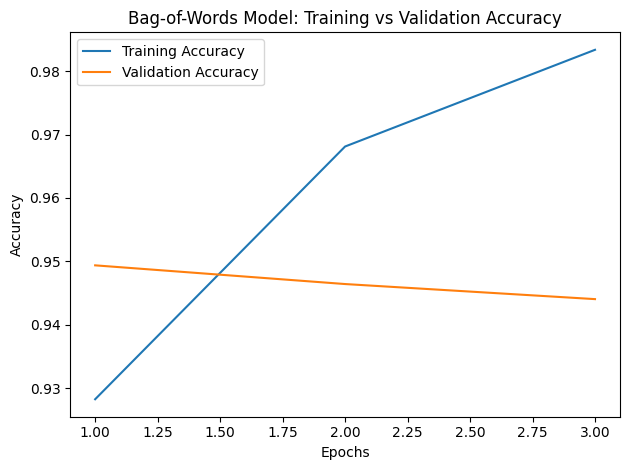

In [ ]:
import matplotlib.pyplot as plt

input_dim = X_train_bow.shape[1]

# Build the model and get history
model_bow, history_bow = build_bow_model(
    X_train_bow,
    y_train_binary,
    X_val_bow,
    y_val_binary,
    input_dim=input_dim
)

# Extract accuracy
acc = history_bow.history['accuracy']
val_acc = history_bow.history['val_accuracy']
epochs = range(1, len(acc) + 1)

# Plot
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Bag-of-Words Model: Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
#evaluate on the test data
from sklearn.metrics import accuracy_score, f1_score

predictions = model_bow.predict(X_test_bow)
predictions_rounded = predictions.round()

accuracy = accuracy_score(y_test_binary, predictions_rounded)
f1 = f1_score(y_test_binary, predictions_rounded)

print(f"Test Accuracy: {accuracy}")
print(f"Test F1 Score: {f1}")



329/329 [==============================] - 1s 2ms/step
Test Accuracy: 0.946141402607289
Test F1 Score: 0.9608141788978123


Our model generalizes well to the testing data with an accuracy of ~95% and an F1 score of 96%.

# Multi Class Models:

Baseline model: Logistic regression without embeddings, only one dense layer, multiclass output

In [ ]:
#tokenize and vectorize text
max_features = 10000
sequence_length = 500 #will pad sequences to length 500

vectorize_layer = layers.TextVectorization(max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

#adapting vectorize layer to X_train
vectorize_layer.adapt(X_train)

In [ ]:
#sanity check: try vectorizing first five examples of X_train
for text in X_train['0'][:5]:
    print(text)
    print(vectorize_layer(text))

feel really weirdly almost always horny really depress normal
tf.Tensor(
[   2   18 3408  156   48 3580   18   97  173    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    

In [ ]:
#vocabulary examples
print("1287 ---> ",vectorize_layer.get_vocabulary()[1287])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

1287 --->  curious
 313 --->  second
Vocabulary size: 10000


In [ ]:
#applying vectorization to train, test and val
X_train_vectorized = vectorize_layer(X_train)
X_test_vectorized = vectorize_layer(X_test)
X_val_vectorized = vectorize_layer(X_val)

In [ ]:
#Reshape arrays to work better with tf
y_train_binary = y_train_binary.reshape(-1, 1)
y_val_binary = y_val_binary.reshape(-1, 1)
y_test_binary = y_test_binary.reshape(-1, 1)
print(y_train_binary.shape)
print(y_val_binary.shape)
print(y_test_binary.shape)

(31524, 1)
(10508, 1)
(10509, 1)


In [ ]:

#combining train, test and val into datasets
train_ds = tf.data.Dataset.from_tensor_slices((X_train_vectorized, y_train))
test_ds = tf.data.Dataset.from_tensor_slices((X_test_vectorized, y_test))
val_ds = tf.data.Dataset.from_tensor_slices((X_val_vectorized, y_val))

#configuring dataset for performance
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

train_ds = train_ds.map(lambda x, y: (tf.cast(x, tf.float32), y))
train_ds = train_ds.batch(64)
val_ds = val_ds.map(lambda x, y: (tf.cast(x, tf.float32), y))
val_ds = val_ds.batch(64)
test_ds = test_ds.map(lambda x, y: (tf.cast(x, tf.float32), y))
test_ds = test_ds.batch(64)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)

model_baseline = tf.keras.Sequential()
model_baseline.add(layers.InputLayer(input_shape=(500,)))
model_baseline.add(layers.Dense(7, activation='softmax'))
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
model_baseline.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

Epoch 1/10
493/493 [==============================] - 2s 4ms/step - loss: 277.4599 - accuracy: 0.3271 - val_loss: 260.5712 - val_accuracy: 0.3774
Epoch 2/10
493/493 [==============================] - 2s 4ms/step - loss: 243.4422 - accuracy: 0.3307 - val_loss: 260.9951 - val_accuracy: 0.2942
Epoch 3/10
493/493 [==============================] - 2s 4ms/step - loss: 239.8243 - accuracy: 0.3283 - val_loss: 263.0027 - val_accuracy: 0.3719
Epoch 4/10
493/493 [==============================] - 2s 4ms/step - loss: 239.8372 - accuracy: 0.3311 - val_loss: 277.8186 - val_accuracy: 0.3671
Epoch 5/10
493/493 [==============================] - 2s 4ms/step - loss: 237.3010 - accuracy: 0.3326 - val_loss: 292.1127 - val_accuracy: 0.2885
Epoch 6/10
493/493 [==============================] - 2s 4ms/step - loss: 237.9892 - accuracy: 0.3323 - val_loss: 302.6898 - val_accuracy: 0.2564
Epoch 7/10
493/493 [==============================] - 2s 4ms/step - loss: 233.9043 - accuracy: 0.3309 - val_loss: 296.8814 -

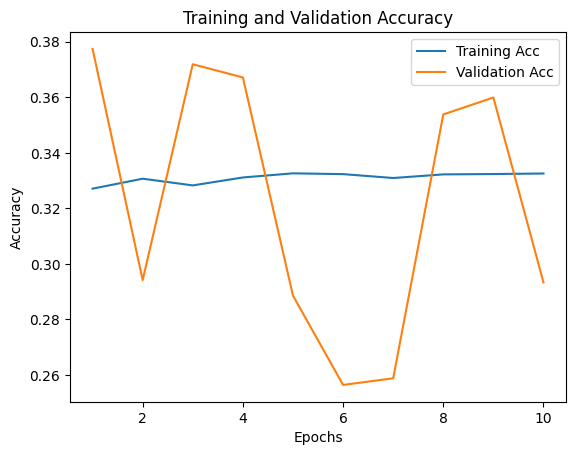

In [ ]:
history_baseline = model_baseline.fit(train_ds, validation_data=val_ds, epochs=10)

history_dict = history_baseline.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, label='Training Acc')
plt.plot(epochs, val_acc, label='Validation Acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [ ]:
from sklearn.metrics import f1_score, classification_report

y_test_pred = model_baseline.predict(X_test_vectorized)
y_test_pred = np.argmax(y_test_pred, axis=1)
test_f1 = f1_score(y_test, y_test_pred, average='weighted')
print(f"Test F1 Score: {test_f1}")
print("Test Classification Report:\n", classification_report(y_test, y_test_pred))


329/329 [==============================] - 0s 1ms/step
Test F1 Score: 0.2993632209854064
Test Classification Report:
               precision    recall  f1-score   support

           0       0.09      0.08      0.08       776
           1       0.08      0.11      0.09       539
           2       0.30      0.37      0.33      3069
           3       0.61      0.42      0.49      3281
           4       0.03      0.01      0.02       217
           5       0.08      0.28      0.12       513
           6       0.24      0.12      0.16      2114

    accuracy                           0.29     10509
   macro avg       0.20      0.20      0.19     10509
weighted avg       0.34      0.29      0.30     10509



Accuracy of the baseline linear regression model is only 34%.

Best Model: Feature Engineering - combining stress/anxiety and depression/suicidal classes

In [ ]:
#change 5 to 0 and 6 to 2 in y_train
y_train_condensed = y_train['0'].map(lambda x: 0 if x == 5 else x)
y_train_condensed = y_train_condensed.map(lambda x: 2 if x == 6 else x)
y_test_condensed = y_test['0'].map(lambda x: 0 if x == 5 else x)
y_test_condensed = y_test_condensed.map(lambda x: 2 if x == 6 else x)
y_val_condensed = y_val['0'].map(lambda x: 0 if x == 5 else x)
y_val_condensed = y_val_condensed.map(lambda x: 2 if x == 6 else x)

#combining train, test and val into datasets
train_cond = tf.data.Dataset.from_tensor_slices((X_train_vectorized, y_train_condensed))
test_cond = tf.data.Dataset.from_tensor_slices((X_test_vectorized, y_test_condensed))
val_cond = tf.data.Dataset.from_tensor_slices((X_val_vectorized, y_val_condensed))

#configuring dataset for performance
AUTOTUNE = tf.data.AUTOTUNE

train_cond = train_cond.cache().prefetch(buffer_size=AUTOTUNE)
val_cond = val_cond.cache().prefetch(buffer_size=AUTOTUNE)
test_cond = test_cond.cache().prefetch(buffer_size=AUTOTUNE)

train_cond = train_cond.map(lambda x, y: (tf.cast(x, tf.float32), y))
train_cond = train_cond.batch(64)
val_cond = val_cond.map(lambda x, y: (tf.cast(x, tf.float32), y))
val_cond = val_cond.batch(64)
test_cond = test_cond.map(lambda x, y: (tf.cast(x, tf.float32), y))
test_cond = test_cond.batch(64)

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
embedding_dim = 48

model_cond = tf.keras.Sequential([
    layers.Embedding(10000, embedding_dim),
    layers.Dropout(0.2),
    layers.GlobalAveragePooling1D(),
    layers.Dropout(0.2),
    layers.Dense(5, activation='softmax')
])

Epoch 1/50
493/493 [==============================] - 12s 23ms/step - loss: 0.8574 - accuracy: 0.6917 - val_loss: 0.6168 - val_accuracy: 0.7884
Epoch 2/50
493/493 [==============================] - 11s 22ms/step - loss: 0.5623 - accuracy: 0.8066 - val_loss: 0.4950 - val_accuracy: 0.8258
Epoch 3/50
493/493 [==============================] - 11s 22ms/step - loss: 0.4452 - accuracy: 0.8523 - val_loss: 0.4441 - val_accuracy: 0.8473
Epoch 4/50
493/493 [==============================] - 11s 22ms/step - loss: 0.3765 - accuracy: 0.8789 - val_loss: 0.4181 - val_accuracy: 0.8619
Epoch 5/50
493/493 [==============================] - 11s 22ms/step - loss: 0.3276 - accuracy: 0.8950 - val_loss: 0.4097 - val_accuracy: 0.8672
Epoch 6/50
493/493 [==============================] - 11s 22ms/step - loss: 0.2917 - accuracy: 0.9070 - val_loss: 0.4112 - val_accuracy: 0.8725
Epoch 7/50
493/493 [==============================] - 11s 22ms/step - loss: 0.2628 - accuracy: 0.9175 - val_loss: 0.4164 - val_accuracy:

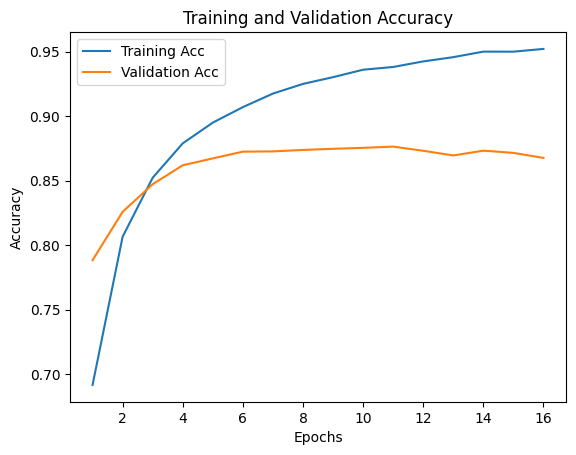

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
model_cond.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# define an instance of the early_stopping class
early_stopping = tf.keras.callbacks.EarlyStopping(
monitor='val_accuracy',
verbose=1,
patience=5,
mode='max',
restore_best_weights=True)

history_cond = model_cond.fit(
    train_cond,
    validation_data=val_cond,
    epochs=50,
    callbacks=[early_stopping]
)

model_cond.summary()

history_dict_3 = history_cond.history
acc = history_dict_3['accuracy']
val_acc = history_dict_3['val_accuracy']
loss = history_dict_3['loss']
val_loss = history_dict_3['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, label='Training Acc')
plt.plot(epochs, val_acc, label='Validation Acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


In [ ]:
#testing model on test data
y_test_pred = model_cond.predict(X_test_vectorized)
y_test_pred = np.argmax(y_test_pred, axis=1)
test_f1 = f1_score(y_test_condensed, y_test_pred, average='weighted')
test_accuracy = accuracy_score(y_test_condensed, y_test_pred)


print(f"Test Accuracy: {test_accuracy}")
print(f"Test F1 Score: {test_f1}")

print("Test Classification Report:\n", classification_report(y_test_condensed, y_test_pred))

329/329 [==============================] - 1s 2ms/step
Test Accuracy: 0.879246360262632
Test F1 Score: 0.8770709618862627
Test Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.73      0.75      1289
           1       0.88      0.69      0.77       539
           2       0.90      0.92      0.91      5183
           3       0.89      0.92      0.91      3281
           4       0.86      0.54      0.66       217

    accuracy                           0.88     10509
   macro avg       0.86      0.76      0.80     10509
weighted avg       0.88      0.88      0.88     10509



The model's accuracy and F1 Score on the test data is ~88%.